In [61]:
%matplotlib notebook

### reference: https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [3]:
torch.__version__

'1.7.0+cu101'

In [4]:
torch.__version__

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
MAX_LENGTH = 15

In [6]:
bos = 0
eos = 1
pad = 2

In [7]:
inverse_map = {
    'a':'z',
    'b':'y',
    'c':'x',
    'd':'w',
    'e':'v',
    'f':'u',
    'g':'t',
    'h':'s',
    'i':'r',
    'j':'q',
    'k':'p',
    'l':'o',
    'm':'n',
    'n':'m',
    'o':'l',
    'p':'k',
    'q':'j',
    'r':'i',
    's':'h',
    't':'g',
    'u':'f',
    'v':'e',
    'w':'d',
    'x':'c',
    'y':'b',
    'z':'a'
}

In [8]:
a2i = {
    '<s>':0,
    '</s>':1,
    '<pad>':2,
    'a':3,
    'b':4,
    'c':5,
    'd':6,
    'e':7,
    'f':8,
    'g':9,
    'h':10,
    'i':11,
    'j':12,
    'k':13,
    'l':14,
    'm':15,
    'n':16,
    'o':17,
    'p':18,
    'q':19,
    'r':20,
    's':21,
    't':22,
    'u':23,
    'v':24,
    'w':25,
    'x':26,
    'y':27,
    'z':28,
}

In [9]:
i2a = {v:k for k, v in a2i.items()}

In [10]:
i2a

{0: '<s>',
 1: '</s>',
 2: '<pad>',
 3: 'a',
 4: 'b',
 5: 'c',
 6: 'd',
 7: 'e',
 8: 'f',
 9: 'g',
 10: 'h',
 11: 'i',
 12: 'j',
 13: 'k',
 14: 'l',
 15: 'm',
 16: 'n',
 17: 'o',
 18: 'p',
 19: 'q',
 20: 'r',
 21: 's',
 22: 't',
 23: 'u',
 24: 'v',
 25: 'w',
 26: 'x',
 27: 'y',
 28: 'z'}

In [11]:
def generate_random_alphabet_index():
    random_length = np.random.randint(10, MAX_LENGTH-2)    # -2 because of <s> and </s>
    random_alphabet_index = np.random.randint(0, 26, random_length) + 3
    return random_alphabet_index.tolist(), random_length

In [115]:
def make_alphabet_tensor():
    indice, length = generate_random_alphabet_index()
    indice = indice + [pad]*(MAX_LENGTH-length)
    return torch.tensor([indice]).to(device)

In [12]:
class AlphabetToyDataset(Dataset):
    def __init__(self, n_dataset=1000):
        bos = 0
        eos = 1
        pad = 2
        self.inputs = []
        self.labels = []
        self.length = []
        for _ in range(n_dataset):
            # make input example
            aindex, alen = generate_random_alphabet_index()
            
            # index to alphabet
            #alphabet = list(map(lambda a: i2a[a], aindex))
            
            # inversing
            #inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
            # alphabet to index
            #iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            iindex = aindex[::-1]
            
            # add bos, eos and pad
            n_pad = MAX_LENGTH - len(aindex) - 1
            aindex = aindex + [eos] + [pad]*n_pad
            iindex = iindex + [eos] + [pad]*n_pad
            
            # add to examples
            self.inputs.append(aindex)
            self.labels.append(iindex)
            self.length.append(alen)
            
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return [
            torch.tensor(self.inputs[index], dtype=torch.long),
            torch.tensor(self.labels[index], dtype=torch.long),
            torch.tensor(self.length[index], dtype=torch.long)
        ]

In [13]:
# class AlphabetToyDataset(Dataset):
#     def __init__(self, n_dataset=1000):
#         bos = 0
#         eos = 1
#         pad = 2
#         self.inputs = []
#         self.labels = []
#         for _ in range(n_dataset):
#             # make input example
#             aindex = generate_random_alphabet_index()
            
#             # index to alphabet
#             alphabet = list(map(lambda a: i2a[a], aindex))
            
#             # inversing
#             inversed_alphabet = list(map(lambda a: inverse_map[a], alphabet))
            
#             # alphabet to index
#             iindex = list(map(lambda ia: a2i[ia], inversed_alphabet))
            
#             # add bos, eos and pad
#             n_pad = MAX_LENGTH - len(aindex) - 2
#             aindex = aindex + [eos]
#             iindex = iindex + [eos]
            
#             # add to examples
#             self.inputs.append(aindex)
#             self.labels.append(iindex)
            
#     def __len__(self):
#         return len(self.inputs)
    
#     def __getitem__(self, index):
#         return [
#             torch.tensor(self.inputs[index], dtype=torch.long),
#             torch.tensor(self.labels[index], dtype=torch.long)
#         ]

In [14]:
train_dataset = AlphabetToyDataset(n_dataset=3000)
valid_dataset = AlphabetToyDataset(n_dataset=300)

In [15]:
len(train_dataset), len(valid_dataset)

(3000, 300)

In [16]:
def convert_index_to_alphabet(index):
    alphabet = list(map(lambda i: i2a[i], index))
    return ' '.join(alphabet)

In [17]:
for i in range(3):
    ex = train_dataset[i]
    aindex, iindex, length = ex
    
    print('aindex_{}: {}'.format(len(aindex), convert_index_to_alphabet(aindex.numpy())))
    print('iindex_{}: {}'.format(len(iindex), convert_index_to_alphabet(iindex.numpy())))
    print('** aindex_{}: {}'.format(len(aindex), aindex))
    print('** iindex_{}: {}'.format(len(iindex), iindex))
    print('------------')

aindex_15: n l k a a r g l n a </s> <pad> <pad> <pad> <pad>
iindex_15: a n l g r a a k l n </s> <pad> <pad> <pad> <pad>
** aindex_15: tensor([16, 14, 13,  3,  3, 20,  9, 14, 16,  3,  1,  2,  2,  2,  2])
** iindex_15: tensor([ 3, 16, 14,  9, 20,  3,  3, 13, 14, 16,  1,  2,  2,  2,  2])
------------
aindex_15: j g j n e r p q l p v </s> <pad> <pad> <pad>
iindex_15: v p l q p r e n j g j </s> <pad> <pad> <pad>
** aindex_15: tensor([12,  9, 12, 16,  7, 20, 18, 19, 14, 18, 24,  1,  2,  2,  2])
** iindex_15: tensor([24, 18, 14, 19, 18, 20,  7, 16, 12,  9, 12,  1,  2,  2,  2])
------------
aindex_15: d v p v d n r y r p v q </s> <pad> <pad>
iindex_15: q v p r y r n d v p v d </s> <pad> <pad>
** aindex_15: tensor([ 6, 24, 18, 24,  6, 16, 20, 27, 20, 18, 24, 19,  1,  2,  2])
** iindex_15: tensor([19, 24, 18, 20, 27, 20, 16,  6, 24, 18, 24,  6,  1,  2,  2])
------------


In [18]:
def collate_fn(batch):
    inputs = pad_sequence([b[0] for b in batch], batch_first=True)
    targets = pad_sequence([b[1] for b in batch], batch_first=True)
    lengths = torch.stack([b[2] for b in batch])

    lengths, indice = torch.sort(lengths, descending=True)
    inputs = inputs[indice]
    targets = targets[indice]
    return inputs, targets, lengths

In [19]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16)
valid_dataloader = DataLoader(valid_dataset, collate_fn=collate_fn, batch_size=1)

In [188]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        '''
        Input Parameters
        - inputs: (B,M)
        - hidden: (1,B,H)
        
        Output returns
        - output: (B,M,H)
        - hidden: (1,B,H)
        
        Logging outputs
        ** inputs: torch.Size([16, 5])
        ** hidden: torch.Size([1, 16, 256])
        ** embedded: torch.Size([16, 5, 256])
        ** final-output: torch.Size([16, 5, 256])
        ** final-hidden: torch.Size([1, 16, 256])
        '''
        #print('** inputs: {}'.format(inputs.shape))
        #print('** hidden: {}'.format(hidden.shape))
        embedded = self.embedding(inputs)    # (B,M,H)
        #print('** embedded: {}'.format(embedded.shape))
        output, hidden = self.gru(embedded, hidden)    # (B,M,H), (1,B,H)
        #print('** final-output: {}'.format(output.shape))
        #print('** final-hidden: {}'.format(hidden.shape))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [185]:
enc = EncoderRNN(26+3, hidden_size).to(device)

In [186]:
inp = torch.from_numpy(np.array([
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
    [1,2,3,4,5],
]))
inp = inp.to(device)
hid = enc.initHidden(inp.size(0))

In [187]:
o, h = enc(inp, hid)
o.shape, h.shape

** inputs: torch.Size([16, 5])
** hidden: torch.Size([1, 16, 256])
** embedded: torch.Size([16, 5, 256])
** final-output: torch.Size([16, 5, 256])
** final-hidden: torch.Size([1, 16, 256])


(torch.Size([16, 5, 256]), torch.Size([1, 16, 256]))

In [21]:
# without Attention
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        #print('DecoderRNN_INPUT: input: {} → {:.4f}'.format(input.shape, input.sum()))
        #print('DecoderRNN_INPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        #print('** output: {} → {:.4f}'.format(output.shape, output.sum()))
        
        
        output, hidden = self.gru(output, hidden)
        #print('** gru-output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('** gru-hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        
        output = self.softmax(self.out(output[0]))
        #print('** hidden: {}'.format(hidden.shape))
        
        #print('DecoderRNN_OUTPUT: output: {} → {:.4f}'.format(output.shape, output.sum()))
        #print('DecoderRNN_OUTPUT: hidden: {} → {:.4f}'.format(hidden.shape, hidden.sum()))
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [22]:
# with attention
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, inputs, hidden, encoder_outputs):
        '''
        Input Parameters
        - inputs: (B,1)
        - hidden: (1,B,H)
        - encoder_outputs: (B,M,H)
        
        Output returns
        - output: (B,1,O)
        - hidden: (B,1,H)
        - attn_weights: (B,1,M)
        
        Logging outputs
        ** inputs: torch.Size([16, 1])
        ** hidden: torch.Size(v[1, 16, 256])
        ** encoder_outputs: torch.Size([16, 15, 256])
        ** embedded: torch.Size([16, 1, 256])
        ** attn_weights: torch.Size([16, 1, 15])
        ** attn_weights: tensor([[[0.1068, 0.0260, 0.0466, 0.0421, 0.0885, 0.0843, 0.0718, 0.0575,
                  0.0361, 0.0273, 0.0339, 0.1882, 0.0606, 0.0723, 0.0581]],

                [[0.1634, 0.0374, 0.0518, 0.0382, 0.0771, 0.0577, 0.0624, 0.0658,
                  0.0286, 0.0351, 0.0336, 0.1435, 0.0603, 0.0940, 0.0510]],

                [[0.1191, 0.0284, 0.0447, 0.0361, 0.0816, 0.0879, 0.0675, 0.0523,
                  0.0293, 0.0273, 0.0535, 0.1981, 0.0588, 0.0728, 0.0427]],

                [[0.1043, 0.0357, 0.0479, 0.0426, 0.1006, 0.0658, 0.0556, 0.0538,
                  0.0372, 0.0476, 0.0348, 0.1877, 0.0641, 0.0705, 0.0516]],

                [[0.1179, 0.0354, 0.0404, 0.0565, 0.0785, 0.0645, 0.0700, 0.0685,
                  0.0380, 0.0414, 0.0456, 0.1519, 0.0710, 0.0682, 0.0523]],

                [[0.1363, 0.0500, 0.0404, 0.0383, 0.0748, 0.0674, 0.0733, 0.0520,
                  0.0288, 0.0306, 0.0466, 0.1517, 0.0769, 0.0932, 0.0395]],

                [[0.1429, 0.0315, 0.0380, 0.0411, 0.0754, 0.0555, 0.0701, 0.0626,
                  0.0337, 0.0311, 0.0398, 0.1486, 0.0813, 0.0885, 0.0599]],

                [[0.1183, 0.0333, 0.0422, 0.0445, 0.0842, 0.0600, 0.0854, 0.0732,
                  0.0299, 0.0447, 0.0299, 0.1091, 0.0865, 0.0831, 0.0757]],

                [[0.1145, 0.0353, 0.0372, 0.0386, 0.0867, 0.0568, 0.0840, 0.0514,
                  0.0393, 0.0285, 0.0397, 0.1800, 0.0759, 0.0755, 0.0565]],

                [[0.1614, 0.0251, 0.0357, 0.0470, 0.0903, 0.0756, 0.0521, 0.0419,
                  0.0305, 0.0227, 0.0343, 0.1683, 0.0643, 0.0891, 0.0616]],

                [[0.1152, 0.0248, 0.0413, 0.0535, 0.0836, 0.0599, 0.0707, 0.0559,
                  0.0333, 0.0394, 0.0348, 0.1688, 0.0728, 0.0880, 0.0582]],

                [[0.1475, 0.0310, 0.0462, 0.0446, 0.0865, 0.0484, 0.0775, 0.0775,
                  0.0378, 0.0357, 0.0360, 0.1070, 0.0689, 0.1070, 0.0485]],

                [[0.1168, 0.0299, 0.0347, 0.0407, 0.0787, 0.0605, 0.0683, 0.0517,
                  0.0312, 0.0334, 0.0426, 0.1895, 0.0739, 0.0914, 0.0565]],

                [[0.1122, 0.0315, 0.0371, 0.0409, 0.1061, 0.0805, 0.0861, 0.0475,
                  0.0399, 0.0262, 0.0330, 0.1467, 0.0676, 0.0788, 0.0660]],

                [[0.1491, 0.0363, 0.0410, 0.0398, 0.0919, 0.0586, 0.0605, 0.0647,
                  0.0378, 0.0277, 0.0356, 0.1396, 0.0699, 0.0981, 0.0495]],

                [[0.1127, 0.0238, 0.0486, 0.0385, 0.0809, 0.0726, 0.0829, 0.0495,
                  0.0441, 0.0275, 0.0412, 0.1654, 0.0627, 0.0825, 0.0672]]],
               device='cuda:0', grad_fn=<SoftmaxBackward>)
        ** attn_weights.sum(): torch.Size([])
        ** attn_weights.sum(): 16.0000
        ** attn_applied: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 512])
        ** output: torch.Size([16, 1, 256])
        ** output: torch.Size([16, 1, 256])
        ** hidden: torch.Size([1, 16, 256])
        ** gru-output: torch.Size([16, 1, 256])
        ** gru-hidden: torch.Size([1, 16, 256])
        ** final-output: torch.Size([16, 1, 29])
        ** final-hidden: torch.Size([1, 16, 256])
        ** final-attn_weights: torch.Size([16, 1, 15])
        '''
        embedded = self.embedding(inputs)    # (B,1,H)
        embedded = self.dropout(embedded)
        
        # query: embedded
        # key: hidden
        # value: encoder_outputs
        
        attn_weights = F.softmax(
            self.attn(
                torch.cat((embedded, hidden.transpose(0, 1)), -1)    # (B,1,2H)
            ),    # (B,1,M)
            dim=-1)    # (B,1,M)
        #print('** attn_weights: {}'.format(attn_weights.shape))
        #print('** attn_weights: {}'.format(attn_weights))
        #print('** attn_weights.sum(): {}'.format(attn_weights.sum().shape))
        #print('** attn_weights.sum(): {:.4f}'.format(attn_weights.sum()))
        
        attn_applied = torch.bmm(attn_weights, encoder_outputs)    # (B,1,H)
        #print('** attn_applied: {}'.format(attn_applied.shape))
        #return

        output = torch.cat((embedded, attn_applied), -1)    # (B,1,2H)
        #print('** output: {}'.format(output.shape))
        output = self.attn_combine(output)    # (B,1,H)
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        
        output = F.relu(output)
        #print('** output: {}'.format(output.shape))    # (B,1,H)
        #print('** hidden: {}'.format(hidden.shape))    # (B,1,H)
        output, hidden = self.gru(output, hidden)    # (B,1,H) (1,B,H)
        #print('** gru-output: {}'.format(output.shape))
        #print('** gru-hidden: {}'.format(hidden.shape))

        output = F.log_softmax(self.out(output), dim=-1)
        #print('** final-output: {}'.format(output.shape))
        #print('** final-hidden: {}'.format(hidden.shape))
        #print('** final-attn_weights: {}'.format(attn_weights.shape))
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [23]:
teacher_forcing_ratio = 0.5

In [24]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH, with_attention=True):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    loss = 0

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = torch.tensor([bos]*batch_size, device=device)
    decoder_input = decoder_input.unsqueeze(-1)    # (B,1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False
    
    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input,    # (B,1)
            decoder_hidden,   # (1,B,H)
            encoder_outputs   # (B,M,H)
        )
        decoder_output = decoder_output.squeeze(1)
        
        loss += criterion(decoder_output, target_tensor[:,di])
        
        if use_teacher_forcing:
            decoder_input = target_tensor[:,di].unsqueeze(-1)    # (B,1)
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [25]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [26]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, with_attention=True):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter, batch in enumerate(train_dataloader):
        input_tensor, target_tensor, length_tensor = batch
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)
        length_tensor = length_tensor.to(device)
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion, with_attention=with_attention)
        print_loss_total += loss
        plot_loss_total += loss

        if (iter+1) % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, (iter+1) / n_iters),
                                         (iter+1), (iter+1) / n_iters * 100, print_loss_avg))

        if (iter+1) % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [27]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [100]:
def evaluate(encoder, decoder, input_tensor, max_length=MAX_LENGTH):
    with torch.no_grad():
        batch_size = input_tensor.size(0)
        encoder_hidden = encoder.initHidden(batch_size)
        #print(input_tensor.shape, encoder_hidden.shape)
        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)
        
        decoder_input = torch.tensor([bos]*batch_size, device=device)
        decoder_input = decoder_input.unsqueeze(-1)    # (B,1)
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            #print('** ', decoder_input.shape, decoder_hidden.shape, encoder_outputs.shape)
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input,    # (B,1)
                decoder_hidden,   # (1,B,H)
                encoder_outputs   # (B,M,H)
            )
            decoder_output = decoder_output.squeeze(1)
            decoder_attentions[:, di] = decoder_attention
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi    # (B,1)
            if topi.item() == eos:
                decoded_words.append('</s>')
                break
            else:
                decoded_words.append(i2a[topi.item()])

        return decoded_words, decoder_attentions[:di + 1]

In [42]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [30]:
for t in train_dataloader:
    print(t)
    break

(tensor([[ 6, 24, 18, 24,  6, 16, 20, 27, 20, 18, 24, 19,  1,  2,  2],
        [25, 14, 18, 19, 23,  7, 13, 28,  3, 24, 25, 21,  1,  2,  2],
        [ 4,  7, 25, 18, 16, 17, 27, 27, 21, 10,  6, 19,  1,  2,  2],
        [12,  9, 12, 16,  7, 20, 18, 19, 14, 18, 24,  1,  2,  2,  2],
        [18, 16, 19, 14,  4, 18,  8,  4,  7, 10,  7,  1,  2,  2,  2],
        [20,  7, 20, 20,  5,  7, 21, 20, 14, 10, 25,  1,  2,  2,  2],
        [18, 25, 20,  7,  6, 24, 25, 22, 20, 14, 10,  1,  2,  2,  2],
        [27,  3, 28, 28,  4, 18, 26, 28, 22, 21, 16,  1,  2,  2,  2],
        [16, 25, 27, 15, 20, 25, 11, 10, 13, 14, 16,  1,  2,  2,  2],
        [16, 14, 13,  3,  3, 20,  9, 14, 16,  3,  1,  2,  2,  2,  2],
        [20, 26, 27, 23, 26, 15, 19, 24,  8, 23,  1,  2,  2,  2,  2],
        [13, 27, 19, 21, 12, 11,  4, 11,  8, 21,  1,  2,  2,  2,  2],
        [ 6, 28,  3, 27,  4, 14, 11, 23,  5, 22,  1,  2,  2,  2,  2],
        [17, 16,  5,  8,  6, 12, 28, 17, 27, 14,  1,  2,  2,  2,  2],
        [22, 26, 20

In [31]:
hidden_size = 256
encoder1 = EncoderRNN(26+3, hidden_size).to(device)
decoder1 = AttnDecoderRNN(hidden_size, 26+3, dropout_p=0.1).to(device)

In [32]:
# hidden_size = 256
# encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
# decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

In [33]:
#### Input validation

In [34]:
# trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [35]:
for _ in range(15):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 0s (- 61m 34s) (10 0%) 3.1772
0m 0s (- 60m 42s) (20 0%) 3.1353
0m 1s (- 61m 26s) (30 0%) 2.9836
0m 2s (- 63m 3s) (40 0%) 2.9314
0m 2s (- 64m 14s) (50 0%) 2.8756
0m 3s (- 64m 57s) (60 0%) 2.7924
0m 3s (- 65m 27s) (70 0%) 2.9195
0m 4s (- 65m 41s) (80 0%) 2.8201
0m 4s (- 65m 34s) (90 0%) 2.8958
0m 5s (- 65m 24s) (100 0%) 2.7099
0m 5s (- 65m 15s) (110 0%) 2.7981
0m 6s (- 65m 20s) (120 0%) 2.7033
0m 6s (- 65m 24s) (130 0%) 2.7576
0m 7s (- 65m 39s) (140 0%) 2.7662
0m 7s (- 65m 47s) (150 0%) 2.7134
0m 8s (- 66m 11s) (160 0%) 2.6584
0m 9s (- 66m 19s) (170 0%) 2.7286
0m 9s (- 66m 26s) (180 0%) 2.6278


In [38]:
for _ in range(5):
    trainIters(encoder1, decoder1, 75000, print_every=30, with_attention=True)

0m 1s (- 64m 24s) (30 0%) 0.0871
0m 3s (- 62m 50s) (60 0%) 0.0921
0m 4s (- 62m 26s) (90 0%) 0.0895
0m 6s (- 62m 28s) (120 0%) 0.0790
0m 7s (- 62m 22s) (150 0%) 0.0777
0m 9s (- 62m 23s) (180 0%) 0.0797
0m 1s (- 61m 54s) (30 0%) 0.0590
0m 2s (- 62m 18s) (60 0%) 0.0914
0m 4s (- 62m 6s) (90 0%) 0.0723
0m 5s (- 62m 3s) (120 0%) 0.0513
0m 7s (- 61m 53s) (150 0%) 0.0586
0m 8s (- 61m 37s) (180 0%) 0.0496
0m 1s (- 61m 43s) (30 0%) 0.0467
0m 2s (- 61m 59s) (60 0%) 0.0652
0m 4s (- 61m 54s) (90 0%) 0.0617
0m 5s (- 61m 36s) (120 0%) 0.0476
0m 7s (- 61m 31s) (150 0%) 0.0541
0m 8s (- 61m 30s) (180 0%) 0.0431
0m 1s (- 60m 55s) (30 0%) 0.0472
0m 2s (- 61m 5s) (60 0%) 0.0624
0m 4s (- 61m 7s) (90 0%) 0.0460
0m 5s (- 61m 13s) (120 0%) 0.0330
0m 7s (- 61m 16s) (150 0%) 0.0553
0m 8s (- 61m 15s) (180 0%) 0.0437
0m 1s (- 60m 19s) (30 0%) 0.0413
0m 2s (- 61m 11s) (60 0%) 0.0476
0m 4s (- 61m 16s) (90 0%) 0.0381
0m 5s (- 61m 13s) (120 0%) 0.0280
0m 7s (- 61m 3s) (150 0%) 0.0345
0m 8s (- 61m 7s) (180 0%) 0.0347


In [ ]:
# trainIters(encoder1, decoder1, 75000, print_every=100, with_attention=True)

In [82]:
for d in valid_dataloader:
    print(d[0].shape)
    break

torch.Size([1, 15])


In [101]:
for d in valid_dataloader:
    input_tensor, target_tensor, length_tensor = d
    input_string = list(map(lambda i: i2a[i], input_tensor.numpy()[0]))
    output_string = list(map(lambda i: i2a[i], target_tensor.numpy()[0]))
    input_string = np.array(input_string)
    output_string = np.array(output_string)
    print('input: {}'.format(input_string))
    print('output: {}'.format(output_string))
    
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)
    length_tensor = length_tensor.to(device)
    
    pred, attn_weight = evaluate(encoder1, decoder1, input_tensor)
    pred = np.array(pred)
    print('pred: {}'.format(pred))
    print('-------------')
    #break

input: ['a' 'y' 'j' 'a' 'q' 'n' 'i' 'g' 'a' 'a' 'w' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['w' 'a' 'a' 'g' 'i' 'n' 'q' 'a' 'j' 'y' 'a' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['w' 'a' 'g' 'i' 'n' 'q' 'a' 'j' 'a' 'y' 'a' '</s>']
-------------
input: ['h' 'p' 'y' 'o' 'o' 'q' 'w' 'd' 'k' 'a' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['a' 'k' 'd' 'w' 'q' 'o' 'o' 'y' 'p' 'h' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['a' 'k' 'd' 'w' 'q' 'o' 'o' 'y' 'p' 'h' '</s>']
-------------
input: ['q' 'd' 'n' 'm' 'l' 'z' 'b' 'v' 'g' 'w' 'x' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['x' 'w' 'g' 'v' 'b' 'z' 'l' 'm' 'n' 'd' 'q' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['x' 'w' 'g' 'v' 'b' 'z' 'l' 'm' 'n' 'd' 'q' '</s>']
-------------
input: ['l' 'r' 'x' 'j' 'y' 'v' 's' 'v' 'd' 'v' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['v' 'd' 'v' 's' 'v' 'y' 'j' 'x' 'r' 'l' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['v' 'd' 'v' 's' 'v' 'y' 'j' 'x' 'r' 'l' '</s>']
-------------
input: ['y' 't' 

pred: ['n' 't' 'z' 's' 'z' 's' 'a' 'r' 'y' 'k' 't' '</s>']
-------------
input: ['u' 'w' 'a' 'y' 'r' 'r' 'e' 'x' 'a' 'p' 'x' 'u' '</s>' '<pad>' '<pad>']
output: ['u' 'x' 'p' 'a' 'x' 'e' 'r' 'r' 'y' 'a' 'w' 'u' '</s>' '<pad>' '<pad>']
pred: ['u' 'x' 'p' 'a' 'x' 'e' 'r' 'r' 'y' 'a' 'w' 'u' '</s>']
-------------
input: ['s' 'k' 'n' 'k' 's' 'u' 'n' 'e' 'n' 'n' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['n' 'n' 'e' 'n' 'u' 's' 'k' 'n' 'k' 's' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['n' 'n' 'e' 'n' 'u' 's' 'k' 'n' 'k' 's' '</s>']
-------------
input: ['o' 'b' 'i' 'v' 'j' 'd' 'n' 'm' 'u' 'y' 'w' 'z' '</s>' '<pad>' '<pad>']
output: ['z' 'w' 'y' 'u' 'm' 'n' 'd' 'j' 'v' 'i' 'b' 'o' '</s>' '<pad>' '<pad>']
pred: ['z' 'w' 'y' 'u' 'm' 'n' 'd' 'j' 'v' 'i' 'b' 'o' '</s>']
-------------
input: ['b' 'd' 'w' 'q' 'i' 'p' 'l' 'p' 'm' 'c' 'd' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['d' 'c' 'm' 'p' 'l' 'p' 'i' 'q' 'w' 'd' 'b' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['d' 'c' 'm' 'p' 'l' 'p' '

input: ['l' 'e' 'e' 'k' 'e' 'p' 'n' 's' 'x' 'i' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['i' 'x' 's' 'n' 'p' 'e' 'k' 'e' 'e' 'l' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['i' 'x' 's' 'n' 'p' 'e' 'k' 'e' 'e' 'l' '</s>']
-------------
input: ['a' 'f' 'n' 'v' 'v' 'v' 'i' 'x' 'q' 'y' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['y' 'q' 'x' 'i' 'v' 'v' 'v' 'n' 'f' 'a' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['y' 'q' 'x' 'i' 'v' 'v' 'v' 'n' 'f' 'a' '</s>']
-------------
input: ['a' 'i' 'w' 'z' 'l' 'w' 't' 'n' 'n' 'l' 'j' 'g' '</s>' '<pad>' '<pad>']
output: ['g' 'j' 'l' 'n' 'n' 't' 'w' 'l' 'z' 'w' 'i' 'a' '</s>' '<pad>' '<pad>']
pred: ['g' 'j' 'j' 'n' 'n' 't' 'w' 'l' 'z' 'w' 'i' 'a' '</s>']
-------------
input: ['c' 'z' 'q' 'f' 'e' 'w' 'i' 'l' 'c' 'e' 'a' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['a' 'e' 'c' 'l' 'i' 'w' 'e' 'f' 'q' 'z' 'c' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['a' 'e' 'c' 'l' 'i' 'w' 'e' 'f' 'q' 'z' 'c' '</s>']
-------------
input: ['q' 'p' 'w' 'y

input: ['q' 'x' 'a' 'd' 'c' 'i' 'i' 'x' 'n' 'a' 'g' 'u' '</s>' '<pad>' '<pad>']
output: ['u' 'g' 'a' 'n' 'x' 'i' 'i' 'c' 'd' 'a' 'x' 'q' '</s>' '<pad>' '<pad>']
pred: ['u' 'g' 'a' 'n' 'x' 'i' 'i' 'c' 'd' 'a' 'x' 'q' '</s>']
-------------
input: ['d' 'a' 's' 'z' 'd' 'p' 'c' 'v' 'q' 'q' 'j' 'v' '</s>' '<pad>' '<pad>']
output: ['v' 'j' 'q' 'q' 'v' 'c' 'p' 'd' 'z' 's' 'a' 'd' '</s>' '<pad>' '<pad>']
pred: ['v' 'j' 'q' 'q' 'v' 'c' 'p' 'd' 'z' 's' 'a' 'd' '</s>']
-------------
input: ['r' 'b' 'b' 'd' 'x' 'r' 'v' 'v' 'l' 'x' 'u' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['u' 'x' 'l' 'v' 'v' 'r' 'x' 'd' 'b' 'b' 'r' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['u' 'x' 'l' 'v' 'v' 'r' 'x' 'd' 'b' 'b' 'r' '</s>']
-------------
input: ['e' 'z' 's' 'u' 'o' 'd' 'e' 'o' 'z' 'w' 'r' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['r' 'w' 'z' 'o' 'e' 'd' 'o' 'u' 's' 'z' 'e' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['r' 'w' 'z' 'o' 'e' 'd' 'o' 'u' 's' 'z' 'e' '</s>']
-------------
input: ['v' 'd' 'm' 'v' 'd' 's' 'p' 

pred: ['t' 'e' 'o' 'l' 'w' 'f' 'v' 'e' 't' 'o' 'm' '</s>']
-------------
input: ['l' 'j' 'p' 'b' 'b' 'h' 'm' 'z' 'a' 'n' 't' 'a' '</s>' '<pad>' '<pad>']
output: ['a' 't' 'n' 'a' 'z' 'm' 'h' 'b' 'b' 'p' 'j' 'l' '</s>' '<pad>' '<pad>']
pred: ['a' 't' 'n' 'a' 'z' 'm' 'h' 'b' 'b' 'p' 'j' 'l' '</s>']
-------------
input: ['u' 'k' 'e' 'o' 'f' 'g' 'l' 'x' 'a' 'v' 'b' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['b' 'v' 'a' 'x' 'l' 'g' 'f' 'o' 'e' 'k' 'u' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['b' 'v' 'a' 'x' 'l' 'g' 'f' 'o' 'e' 'k' 'u' '</s>']
-------------
input: ['b' 'q' 'i' 'f' 'q' 'v' 'w' 'f' 's' 'v' 'k' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['k' 'v' 's' 'f' 'w' 'v' 'q' 'f' 'i' 'q' 'b' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['k' 'v' 's' 'f' 'w' 'v' 'q' 'f' 'i' 'q' 'b' '</s>']
-------------
input: ['i' 'y' 'z' 'k' 'e' 'a' 'w' 'q' 'q' 'd' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['d' 'q' 'q' 'w' 'a' 'e' 'k' 'z' 'y' 'i' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['d' 'q' 'q' 'w'

pred: ['u' 'k' 'y' 's' 'v' 'c' 'x' 'r' 'h' 'x' 's' 'd' '</s>']
-------------
input: ['a' 'y' 'd' 'q' 'q' 'w' 'y' 'g' 'd' 'd' 'v' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['v' 'd' 'd' 'g' 'y' 'w' 'q' 'q' 'd' 'y' 'a' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['v' 'd' 'g' 'y' 'w' 'q' 'q' 'q' 'd' 'y' 'a' '</s>']
-------------
input: ['g' 'r' 'd' 'z' 'l' 'm' 'v' 'y' 't' 'g' 'v' 'q' '</s>' '<pad>' '<pad>']
output: ['q' 'v' 'g' 't' 'y' 'v' 'm' 'l' 'z' 'd' 'r' 'g' '</s>' '<pad>' '<pad>']
pred: ['q' 'v' 'g' 't' 'y' 'v' 'm' 'l' 'z' 'd' 'r' 'g' '</s>']
-------------
input: ['h' 'o' 'b' 'z' 'g' 'l' 't' 'u' 'j' 'a' 'f' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['f' 'a' 'j' 'u' 't' 'l' 'g' 'z' 'b' 'o' 'h' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['f' 'a' 'j' 'u' 't' 'l' 'g' 'z' 'b' 'o' 'h' '</s>']
-------------
input: ['z' 'u' 'v' 'a' 'p' 'c' 'q' 'q' 'x' 'c' 'g' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['g' 'c' 'x' 'q' 'q' 'c' 'p' 'a' 'v' 'u' 'z' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['g' 'c' 'x' 'q' 'q'

pred: ['m' 'q' 'z' 'c' 'w' 'u' 'i' 'r' 'k' 'w' 'c' 'e' '</s>']
-------------
input: ['n' 's' 'x' 'l' 's' 'k' 'l' 's' 'q' 'j' 'o' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['o' 'j' 'q' 's' 'l' 'k' 's' 'l' 'x' 's' 'n' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['o' 'j' 'q' 's' 'l' 'k' 's' 'l' 'x' 's' 'n' '</s>']
-------------
input: ['n' 'm' 'c' 'q' 't' 'a' 'v' 'e' 'd' 'r' 'p' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['p' 'r' 'd' 'e' 'v' 'a' 't' 'q' 'c' 'm' 'n' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['p' 'r' 'd' 'e' 'v' 'a' 't' 'q' 'c' 'm' 'n' '</s>']
-------------
input: ['g' 'f' 'x' 'i' 's' 'j' 'p' 'q' 'p' 'c' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['c' 'p' 'q' 'p' 'j' 's' 'i' 'x' 'f' 'g' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['c' 'p' 'q' 'p' 'j' 's' 'i' 'x' 'f' 'g' '</s>']
-------------
input: ['m' 'e' 'l' 't' 'g' 'm' 'y' 's' 'v' 'o' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
output: ['o' 'v' 's' 'y' 'm' 'g' 't' 'l' 'e' 'm' '</s>' '<pad>' '<pad>' '<pad>'
 '<pad>']
pred: ['

pred: ['t' 'i' 't' 'b' 'z' 'a' 'c' 'b' 'c' 'd' '</s>']
-------------
input: ['s' 'x' 'v' 'r' 'i' 'u' 'z' 'p' 'c' 'c' 'u' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['u' 'c' 'c' 'p' 'z' 'u' 'i' 'r' 'v' 'x' 's' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['u' 'c' 'p' 'z' 'u' 'i' 'r' 'v' 'x' 's' '</s>']
-------------
input: ['r' 'f' 'w' 'l' 'k' 'n' 'h' 'k' 'j' 'e' 'b' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['b' 'e' 'j' 'k' 'h' 'n' 'k' 'l' 'w' 'f' 'r' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['b' 'e' 'j' 'k' 'h' 'n' 'k' 'l' 'w' 'f' 'r' '</s>']
-------------
input: ['f' 'h' 'b' 'b' 'l' 'j' 'o' 'b' 'm' 'b' 'p' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['p' 'b' 'm' 'b' 'o' 'j' 'l' 'b' 'b' 'h' 'f' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['p' 'b' 'm' 'b' 'o' 'j' 'l' 'b' 'b' 'h' 'f' '</s>']
-------------
input: ['c' 'h' 'k' 'p' 'r' 'u' 'f' 'o' 'f' 'a' 'm' '</s>' '<pad>' '<pad>'
 '<pad>']
output: ['m' 'a' 'f' 'o' 'f' 'u' 'r' 'p' 'k' 'h' 'c' '</s>' '<pad>' '<pad>'
 '<pad>']
pred: ['m' 'a' 'f' 'o' 'f' 'u' '

In [102]:
# plt.matshow(attn_weight.numpy())

In [103]:
attn_weight.shape

torch.Size([12, 15])

In [116]:
input_tensor = make_alphabet_tensor()
output_words, attentions = evaluate(encoder1, decoder1, input_tensor)

In [117]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['</s>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [157]:
def evaluateAndShowAttention():
    input_tensor = make_alphabet_tensor()
    output_words, attentions = evaluate(
        encoder1, decoder1, input_tensor)
    
    input_sentence = input_tensor[0].tolist()
    input_sentence = list(map(lambda x: i2a[x], input_sentence))
    print('original input =', input_sentence)
    input_length = input_sentence.index('<pad>')
    input_sentence = ' '.join(input_sentence[:input_length])
    print('input  =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

original input = ['g', 'h', 'p', 'z', 'a', 'i', 'z', 'r', 'm', 'n', 'q', 'h', '<pad>', '<pad>', '<pad>']
input  = g h p z a i z r m n q h
output = h q m r z i a z p h g </s>


<IPython.core.display.Javascript object>


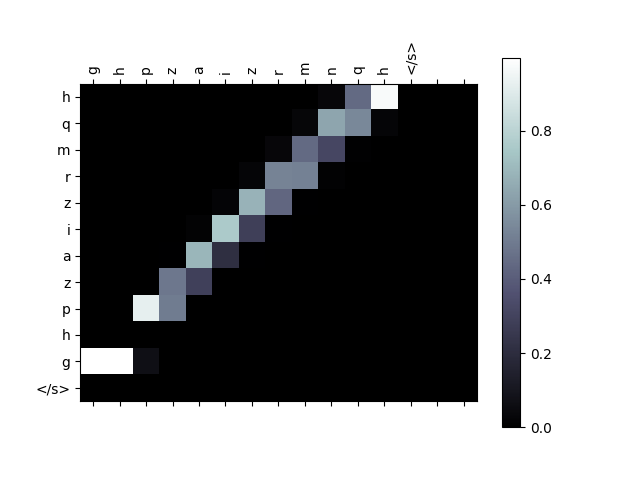

/heavy_data/jkfirst/workspace/git/publish/env_pub/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/heavy_data/jkfirst/workspace/git/publish/env_pub/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


In [163]:
evaluateAndShowAttention()
#evaluateAndShowAttention("elle est trop petit .")
#evaluateAndShowAttention("je ne crains pas de mourir .")
#evaluateAndShowAttention("c est un jeune directeur plein de talent .")

In [164]:
generate_random_alphabet_index()

([23, 11, 13, 12, 7, 14, 5, 20, 18, 25], 10)

In [168]:
for d in train_dataloader:
    inputs, targets, lengths = d
    print(inputs)
    print(targets)
    print(lengths)
    print(inputs.shape, targets.shape, lengths.shape)
    break

tensor([[ 6, 24, 18, 24,  6, 16, 20, 27, 20, 18, 24, 19,  1,  2,  2],
        [25, 14, 18, 19, 23,  7, 13, 28,  3, 24, 25, 21,  1,  2,  2],
        [ 4,  7, 25, 18, 16, 17, 27, 27, 21, 10,  6, 19,  1,  2,  2],
        [12,  9, 12, 16,  7, 20, 18, 19, 14, 18, 24,  1,  2,  2,  2],
        [18, 16, 19, 14,  4, 18,  8,  4,  7, 10,  7,  1,  2,  2,  2],
        [20,  7, 20, 20,  5,  7, 21, 20, 14, 10, 25,  1,  2,  2,  2],
        [18, 25, 20,  7,  6, 24, 25, 22, 20, 14, 10,  1,  2,  2,  2],
        [27,  3, 28, 28,  4, 18, 26, 28, 22, 21, 16,  1,  2,  2,  2],
        [16, 25, 27, 15, 20, 25, 11, 10, 13, 14, 16,  1,  2,  2,  2],
        [16, 14, 13,  3,  3, 20,  9, 14, 16,  3,  1,  2,  2,  2,  2],
        [20, 26, 27, 23, 26, 15, 19, 24,  8, 23,  1,  2,  2,  2,  2],
        [13, 27, 19, 21, 12, 11,  4, 11,  8, 21,  1,  2,  2,  2,  2],
        [ 6, 28,  3, 27,  4, 14, 11, 23,  5, 22,  1,  2,  2,  2,  2],
        [17, 16,  5,  8,  6, 12, 28, 17, 27, 14,  1,  2,  2,  2,  2],
        [22, 26, 20,

In [169]:
attn_weight

tensor([[2.7443e-13, 1.4339e-11, 2.3808e-11, 1.7343e-11, 1.0885e-12, 9.8746e-13,
         2.7909e-11, 1.2766e-08, 3.0502e-05, 2.1871e-02, 4.7709e-01, 9.4481e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [8.9152e-14, 3.7391e-12, 1.1493e-11, 7.2863e-11, 5.2566e-11, 4.8947e-10,
         5.9817e-08, 3.0078e-05, 9.1642e-03, 4.8528e-01, 5.0434e-01, 5.4972e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.5974e-13, 2.2829e-12, 2.1362e-11, 2.8649e-10, 2.9755e-09, 2.6986e-07,
         5.5015e-05, 1.6642e-02, 6.7883e-01, 4.8054e-01, 1.8265e-02, 1.8806e-04,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.4182e-13, 1.4139e-12, 1.7193e-11, 1.9486e-09, 2.2993e-07, 3.1185e-05,
         1.3192e-02, 6.1570e-01, 2.9660e-01, 1.1642e-02, 1.5395e-04, 8.7387e-07,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.1312e-13, 2.5994e-12, 1.2877e-10, 8.4023e-08, 3.5241e-05, 1.3275e-02,
         5.9502e-01, 3.6198e-01, 1.5223e-02, 3.4762e-04, 8.3181e-07, 7.8150e-09,
      